In [1]:
import pandas as pd

In [2]:
from prepare import basic_clean, lemmatize, remove_stopwords

In [3]:
# read in from local
#acquire data from spam_db

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")

In [4]:
# shape check
df.shape

(5572, 2)

In [5]:
# initial value counts
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [6]:
def clean(text):
    return remove_stopwords(lemmatize(basic_clean(text)))

clean('Good morning Innis! We are doing data exploration!')

'good morning innis data exploration'

In [7]:
df.text = df.text.apply(clean)

In [8]:
df.text.head()

id
0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4             nah dont think go usf life around though
Name: text, dtype: object

In [9]:
all_text = ' '.join(df.text)
spam_text = ' '.join(df[df.label == 'spam'].text)
ham_text = ' '.join(df[df.label == 'ham'].text)
all_text = clean(all_text)
spam_text = clean(spam_text)
ham_text = clean(ham_text)

In [10]:
pd.Series(all_text.split()).value_counts()

u           1183
call         600
2            478
im           462
get          397
            ... 
basket         1
dane           1
corrct         1
santha         1
bitching       1
Length: 8886, dtype: int64

In [11]:
ham_freq = pd.Series(ham_text.split()).value_counts()
spam_freq = pd.Series(spam_text.split()).value_counts()
all_freq = pd.Series(all_text.split()).value_counts()

In [12]:
word_counts = pd.concat([all_freq, spam_freq, ham_freq], sort=True, axis=1)
word_counts.columns = ['all', 'spam', 'ham']
word_counts = word_counts.fillna(0).apply(lambda s: s.astype(int))

In [13]:
word_counts.sort_values(by='all', ascending=False)

,all,spam,ham
u,1183,155,1028
call,600,359,241
2,478,173,305
im,462,13,449
get,397,83,314
...,...,...,...
hari,1,0,1
hardest,1,0,1
harder,1,0,1
happiest,1,0,1


In [14]:
word_counts.assign(p_spam=word_counts.spam / word_counts['all'],p_ham=word_counts.ham / word_counts['all'])

,all,spam,ham,p_spam,p_ham
0,3,3,0,1.0,0.0
008704050406,2,2,0,1.0,0.0
0089my,1,1,0,1.0,0.0
0121,1,1,0,1.0,0.0
01223585236,1,1,0,1.0,0.0
...,...,...,...,...,...
zoe,2,1,1,0.5,0.5
zogtorius,1,0,1,0.0,1.0
zoom,1,0,1,0.0,1.0
zouk,1,1,0,1.0,0.0


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

<AxesSubplot:>

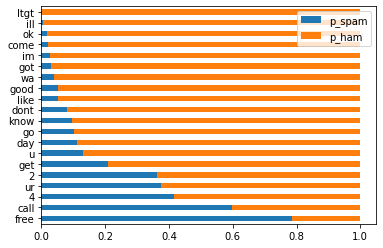

In [16]:
word_counts.assign(p_spam=word_counts.spam / word_counts['all'],p_ham=word_counts.ham / word_counts['all'])\
    .sort_values(by='all')\
    .tail(20)\
    [['p_spam', 'p_ham']]\
    .sort_values(by='p_ham')\
    .plot.barh(stacked=True)

In [17]:
word_counts[(word_counts.spam > 10) & (word_counts.ham > 10)]\
    .assign(ratio=lambda df: df.spam/df.ham)\
    .sort_values(by='ratio')

,all,spam,ham,ratio
im,462,13,449,0.028953
good,235,12,223,0.053812
like,245,13,232,0.056034
need,182,11,171,0.064327
dont,279,22,257,0.085603
...,...,...,...,...
contact,70,56,14,4.000000
win,76,61,15,4.066667
cash,74,62,12,5.166667
mobile,150,135,15,9.000000


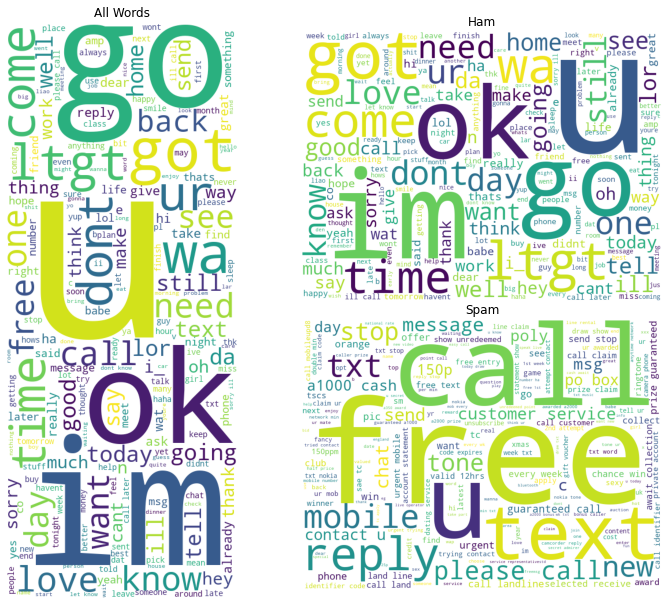

In [18]:
from wordcloud import WordCloud

all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(all_text)
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(ham_text)
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(spam_text)

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

In [19]:
import nltk

list(nltk.ngrams('Mary had a little lamb'.split(), 3))

[('Mary', 'had', 'a'), ('had', 'a', 'little'), ('a', 'little', 'lamb')]

In [20]:
pd.Series(nltk.ngrams(all_text.split(), 2)).value_counts().head(20)

(please, call)         53
(call, later)          52
(ill, call)            48
(let, know)            41
(u, r)                 40
(r, u)                 40
(sorry, ill)           39
(dont, know)           38
(new, year)            32
(wan, 2)               31
(good, morning)        31
(customer, service)    29
(take, care)           26
(u, get)               26
(contact, u)           26
(po, box)              25
(im, going)            24
(u, know)              23
(guaranteed, call)     23
(u, wan)               23
dtype: int64

<AxesSubplot:>

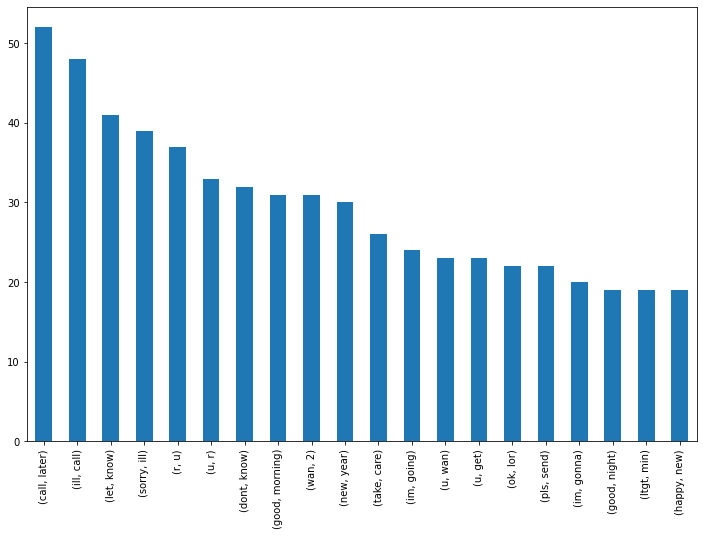

In [21]:
pd.Series(nltk.bigrams(ham_text.split())).value_counts().head(20).plot.bar(figsize=(12,8))

In [22]:
top_20_ham_bigrams = pd.Series(
    (
        nltk.bigrams(
            ham_text.split()
        )
    )).value_counts().head(20)

In [23]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}

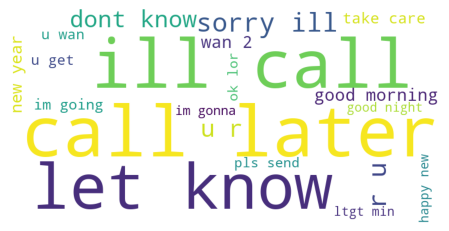

In [24]:
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [25]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_text.split(), 3))
                      .value_counts()
                      .head(20))

In [26]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}

In [27]:
data

{'prize guaranteed call': 21,
 'call customer service': 15,
 'land line claim': 14,
 'reply call 08000930705': 14,
 '2003 account statement': 13,
 'private 2003 account': 13,
 'guaranteed a1000 cash': 12,
 'show 800 unredeemed': 12,
 'camcorder reply call': 12,
 'tone 4 ur': 11,
 'bonus caller prize': 11,
 'please call customer': 11,
 'anytime network min': 11,
 'every week txt': 11,
 'free entry 2': 11,
 'urgent trying contact': 11,
 'a2000 bonus caller': 10,
 'cash await collection': 10,
 'speak live operator': 10,
 'customer service representative': 10}

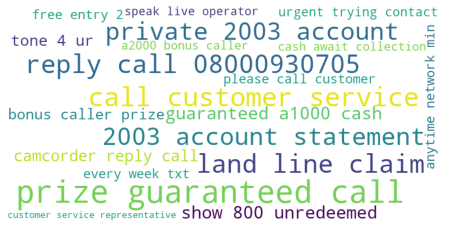

In [28]:
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### Let's take a look at the blog and news articles:

In [29]:
import acquire
import prepare

In [30]:
blogs = acquire.get_blog_articles()
news = acquire.get_news_articles()

fetching https://codeup.com/workshops/virtual/learn-to-code-html-css-on-4-30/


NameError: name 'headers' is not defined

In [ ]:
df_blog = pd.DataFrame(blogs)
df_news = pd.DataFrame(news)

In [ ]:
df_blog.head()

In [ ]:
type(df_blog)

In [ ]:
df_blog.content = df_blog.content.apply(clean)
df_news.content = df_news.content.apply(clean)

In [ ]:
labels = pd.concat([df_news.category.value_counts(),
                    df_news.category.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

In [ ]:
all_news = ' '.join(df_news.content)
tech_news = ' '.join(df_news[df_news.category == 'technology'].content)
bus_news = ' '.join(df_news[df_news.category == 'business'].content)
sports_news = ' '.join(df_news[df_news.category == 'sports'].content)
ent_news = ' '.join(df_news[df_news.category == 'entertainment'].content)

In [ ]:
all_freq = pd.Series(all_news.split()).value_counts()
tech_freq = pd.Series(tech_news.split()).value_counts()
bus_freq = pd.Series(bus_news.split()).value_counts()
sports_freq = pd.Series(sports_news.split()).value_counts()
ent_freq = pd.Series(ent_news.split()).value_counts()

all_freq

In [ ]:
news_word_counts = (pd.concat([all_freq, tech_freq, bus_freq, sports_freq, ent_freq], axis=1, sort=True))\
    .set_axis(['all', 'technology', 'business', 'sports', 'entertainment'], axis=1, inplace=False)
# word_counts = pd.concat([all_freq, spam_freq, ham_freq], sort=True, axis=1)
# word_counts.columns = ['all', 'spam', 'ham']
# word_counts = word_counts.fillna(0).apply(lambda s: s.astype(int))

In [ ]:
news_word_counts = news_word_counts.fillna(0).apply(lambda s: s.astype(int))
news_word_counts.tail()

In [ ]:
news_word_counts.assign(p_tech=news_word_counts.technology / news_word_counts['all'],\
                        p_bus=news_word_counts.business / news_word_counts['all'],\
                        p_sports=news_word_counts.sports / news_word_counts['all'],\
                        p_ent=news_word_counts.entertainment / news_word_counts['all'])\
                        .sort_values(by='all', ascending=False)\
                        .head(20)\
                        [['p_tech', 'p_bus', 'p_sports', 'p_ent']]\
                        .sort_values(by='p_ent')\
                        .plot.barh(stacked=True)
                        

news_word_counts.assign(p_tech=news_word_counts.technology / news_word_counts['all'],\
                        p_bus=news_word_counts.business / news_word_counts['all'],\
                        p_sports=news_word_counts.sports / news_word_counts['all'],\
                        p_ent=news_word_counts.entertainment / news_word_counts['all'])\
                        .sort_values(by='all', ascending=False)\
                        .head(20)\
                        [['p_tech', 'p_bus', 'p_sports', 'p_ent']]\
                        .sort_values(by='p_tech')\
                        .plot.barh(stacked=True)

news_word_counts.assign(p_tech=news_word_counts.technology / news_word_counts['all'],\
                        p_bus=news_word_counts.business / news_word_counts['all'],\
                        p_sports=news_word_counts.sports / news_word_counts['all'],\
                        p_ent=news_word_counts.entertainment / news_word_counts['all'])\
                        .sort_values(by='all', ascending=False)\
                        .head(20)\
                        [['p_tech', 'p_bus', 'p_sports', 'p_ent']]\
                        .sort_values(by='p_sports')\
                        .plot.barh(stacked=True)

news_word_counts.assign(p_tech=news_word_counts.technology / news_word_counts['all'],\
                        p_bus=news_word_counts.business / news_word_counts['all'],\
                        p_sports=news_word_counts.sports / news_word_counts['all'],\
                        p_ent=news_word_counts.entertainment / news_word_counts['all'])\
                        .sort_values(by='all', ascending=False)\
                        .head(20)\
                        [['p_tech', 'p_bus', 'p_sports', 'p_ent']]\
                        .sort_values(by='p_bus')\
                        .plot.barh(stacked=True)

In [ ]:
all_news_cloud = WordCloud(background_color='white', height=1000, width=1000).generate(all_news)
plt.figure(figsize=(10, 10))
plt.imshow(all_news_cloud)

In [ ]:
all_news_cloud = WordCloud(background_color='white', height=1000, width=500).generate(all_news)
tech_cloud = WordCloud(background_color='white', height=250, width=500).generate(tech_news)
sports_cloud = WordCloud(background_color='white', height=250, width=500).generate(sports_news)
ent_cloud = WordCloud(background_color='white', height=250, width=500).generate(ent_news)
bus_cloud = WordCloud(background_color='white', height=250, width=500).generate(bus_news)

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([0.5, 0, 0.5, 0.22]), plt.axes([.5, .25, .5, .22]), plt.axes([.5, .5, .5, .22]), plt.axes([.5, .75, .5, .22])]

axs[0].imshow(all_news_cloud)
axs[1].imshow(tech_cloud)
axs[2].imshow(sports_cloud)
axs[3].imshow(ent_cloud)
axs[4].imshow(bus_cloud)

axs[0].set_title('All news')
axs[1].set_title('Tech News')
axs[2].set_title('Sports News')
axs[3].set_title('Entertainment News')
axs[4].set_title('Business News')

for ax in axs: ax.axis('off')

In [ ]:
top_20_tech_bigrams = (pd.Series(nltk.ngrams(tech_news.split(), 2))
                      .value_counts()
                      .head(20))
top_20_bus_bigrams = (pd.Series(nltk.ngrams(bus_news.split(), 2))
                      .value_counts()
                      .head(20))
top_20_sports_bigrams = (pd.Series(nltk.ngrams(sports_news.split(), 2))
                      .value_counts()
                      .head(20))
top_20_ent_bigrams = (pd.Series(nltk.ngrams(ent_news.split(), 2))
                      .value_counts()
                      .head(20))

In [ ]:
top_20_tech_bigrams

In [ ]:
top_20_tech_bigrams.sort_values().plot.barh(color='green', width=.9, figsize=(10, 6))
plt.title('20 Most frequently occuring Tech News bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_tech_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [ ]:
top_20_sports_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))
plt.title('20 Most frequently occuring Sports News bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_sports_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [ ]:
top_20_ent_bigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))
plt.title('20 Most frequently occuring Entertainment News bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ent_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [ ]:
top_20_bus_bigrams.sort_values().plot.barh(color='plum', width=.9, figsize=(10, 6))
plt.title('20 Most frequently occuring Busines News bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_bus_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [ ]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_tech_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [ ]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_bus_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [ ]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_sports_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [ ]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ent_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [ ]:
df_blog.head()

In [ ]:
all_blog = pd.Series(' '.join(df_blog.content).split())
all_blog_freq = pd.Series(' '.join(df_blog.content).split()).value_counts()

In [ ]:
blog_word_counts = pd.DataFrame(all_blog_freq.sort_values(ascending=False))
blog_word_counts.columns = ['num_occur']
blog_word_counts['word'] = blog_word_counts.index
top_blog_word_counts = blog_word_counts.head(20)
top_blog_word_counts

In [ ]:
import seaborn as sns

In [ ]:
sns.barplot(y = top_blog_word_counts.word, x=top_blog_word_counts.num_occur)